In [1]:
import numpy as np
from alive_progress import alive_bar
import time
from math import sqrt, pi, exp
import functools
import scipy
from varname import nameof
import os
import re

# import algorithms (ULA, ALDI, NRALDI)
from utils.algorithms import * 
# import mog functions (density etc)
from utils.mog_functions import *
# import plot functions
from utils.plot_functions import *


## Test case "Mixture of Gaussians"  

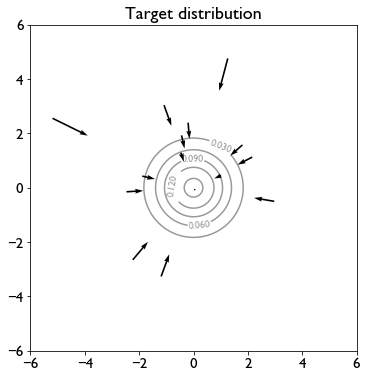

In [33]:
# dimension
d = 2


# parameters of the mixture 

sigma1, sigma2, gap = 1, 1, 0.01


# define (unnormalized) target density, potential, score (gradient log density)

target_unnorm_density = (lambda z : bimodal_distribution(z, gap, sigma1, sigma2))
target_potential = (lambda z: -np.log(target_unnorm_density(z)))
gradient_log_target = (lambda z: gradient_of_log_bimodal_distribution(z,  gap, sigma1, sigma2))

# plot posterior

val = 6
xmin, xmax, ymin, ymax = -val, val, -val, val
nb_grid = 200
u0s = np.linspace(xmin, xmax, nb_grid) # draw a grid of nb_grid points in 2d
u1s = np.linspace(ymin, ymax, nb_grid)
U0, U1 = np.meshgrid(u0s,u1s) # each of the Ui's is of size (200, 200) (all X coordinates of points parallel to Y axis and reverse)
U = np.dstack((U0,U1)) # size (2, nb_grid, nb_grid)

unnorm_dens = target_unnorm_density(U) 

Z = np.trapz(unnorm_dens, u0s, axis=1)
Z = np.trapz(Z, u1s)
dens = unnorm_dens/Z 
marg_over_x = np.trapz(dens, u0s, axis=1)
marg_over_y = np.trapz(dens, u1s, axis=0)

fig, ax = plt.subplots(figsize = (10, 6))

DS = plt.contour(U0, U1, np.exp(-target_potential(U)), 5, alpha=0.4, colors="black")
plt.clabel(DS, inline=1, fontsize=10) # level sets of target


num_particles = 15
particles = np.random.normal(0, 2, size=(num_particles, d))
grad_particles = np.zeros_like(particles)
for i in range(num_particles):
        grad_particles[i] +=  gradient_log_target(particles[i,:])


x_pos = particles[:, 0]
y_pos = particles[:, 1]
x_direct = grad_particles[:, 0]
y_direct = grad_particles[:, 1]

ax.quiver(x_pos, y_pos, x_direct, y_direct, width = 0.005)
ax.set_title('Target distribution')
ax.set_aspect('equal')

## Try algorithms on one experiment

In [41]:
# parameters of all the algorithms

J = 20  # number of particles 
tau = 1e-2 # step size

# parameter of our algorithm (ALDINR)
const = 1.5


# number of iterations
N_sim = 1000

# initialization parameters
mean_init = np.asarray([2,4])
cov_init = [[1, 0], [0, 2]]


In [46]:
# not vectorized
def gradient_of_log_bimodal_distribution(z,  gap, sigma1, sigma2):

    mean1 = np.asarray([-gap/2, 0])
    cov1 = [[sigma1, 0], [0, sigma1]]
    pdf1 = multivariate_normal(mean1, cov1).pdf(z) 
    

    mean2 = np.asarray([gap/2, 0])
    cov2 = [[sigma2, 0], [0, sigma2]]
    pdf2 = multivariate_normal(mean2, cov2).pdf(z)


    gradient= - (1/(bimodal_distribution(z, gap, sigma1, sigma2))+1e-9)*(0.5*pdf1*np.matmul(np.linalg.inv(cov1),(z - mean1))\
                                                     +0.5*pdf2*np.matmul(np.linalg.inv(cov2),(z - mean2)))
    
    return gradient




# run aldinr
u0 = np.random.multivariate_normal(mean_init, cov_init, J).T

d, J = u0.shape    
us_list_ALDINR = np.zeros((d,J,N_sim))
us_list_ALDINR[:,:,0] = u0

# to track the convergence
#preconditioners = np.ones((d, d, N_sim)) # product of (D_opt+J_opt)K^{-1}
#preconditioners[:, :, 0] = np.cov(u0)*(J-1)/J
covariances = np.ones((d, d, N_sim))

with alive_bar(N_sim, force_tty = True) as bar:
    for n in range(N_sim-1):    

        time.sleep(.001)

        us = us_list_ALDINR[:, :, n] # shape (d, J)
        m_us = np.mean(us, axis=1)[:,np.newaxis] # shape (2, 1)
        C = np.cov(us)*(J-1)/J # shape (2,2)

        # compute sqrt C
        print(C)
        sqrtC = scipy.linalg.sqrtm(C)

        # compute D
        D_opt_tilde, v, lambda_min = construct_D_opt_tilde(C,d)
        if lambda_min> 500:
            print("ALDINR diverging")

        D_opt = construct_D_opt(C,d)

        if np.mod(n, 1) == 0:
            print("iter")
            print(n)
            print("lambda min")
            print(lambda_min)
            #print(C)

        # compute psis
        psis = construct_onb(d, v)

        # compute sqrt D
        sqrtD = scipy.linalg.sqrtm(D_opt) # we should be able to do something cheap here

        # compute J opt
        J_opt = construct_J_opt(psis, v, lambda_min, const, d, sqrtC)

        T = J_opt + D_opt

        vs = np.zeros_like(us)
        for i in range(us.shape[1]): # for each particle compute the score
            vs[:, i] +=  gradient_log_target(us[:, i])#.reshape((2,1))

        drift = + np.dot(T, vs) 
        noise = np.random.normal(0,1,(2,J))
        diff = np.sqrt(2) * np.dot(sqrtD,noise) 


        us_list_ALDINR[:, :, n+1] = us + tau * drift  + np.sqrt(tau) * diff 

        # keep record of some stats
        #preconditioners[:, :, n] = T
        covariances[:, :, n] = C
        bar()


on 0: [[0.74123881 0.19800447]                                                  
       [0.19800447 0.9114054 ]]
on 0: iter                                                                      
on 0: 0                                                                         
on 0: lambda min                                                                
on 0: 0.610811231807979                                                         
on 1: [[0.85249405 0.19251749]                                                  
       [0.19251749 0.87136916]]
on 1: iter                                                                      
on 1: 1                                                                         
on 1: lambda min                                                                
on 1: 0.6691829254060452                                                        
on 2: [[0.95771585 0.13982429]                                                  
       [0.13982429 0.87767477]]
on 2: iter   

on 11: /var/folders/_t/h78tns5s2990dvmw2d6kzfyw0000gn/T/ipykernel_58936/1603467133.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
         us_list_ALDINR[:, :, n+1] = us + tau * drift  + np.sqrt(tau) * diff


on 12: [[0.61745573 0.11721453]                                                 
        [0.11721453 1.14679613]]
on 12: iter                                                                     
on 12: 12                                                                       
on 12: lambda min                                                               
on 12: 0.5926616645953289                                                       
on 13: [[0.53696663 0.05732601]                                                 
        [0.05732601 1.17656056]]
on 13: iter                                                                     
on 13: 13                                                                       
on 13: lambda min                                                               
on 13: 0.5318691975820882                                                       
on 14: [[0.59717712 0.03059071]                                                 
        [0.03059071 1.18164398]]
on 14: ite

on 30: lambda min                                                               
on 30: 0.6910991897368496                                                       
on 31: [[ 0.71892073 -0.21066406]                                               
        [-0.21066406  1.15992596]]
on 31: iter                                                                     
on 31: 31                                                                       
on 31: lambda min                                                               
on 31: 0.6344631029241027                                                       
on 32: [[ 0.81590914 -0.27595165]                                               
        [-0.27595165  1.09296522]]
on 32: iter                                                                     
on 32: 32                                                                       
on 32: lambda min                                                               
on 32: 0.6456664988840719              

on 49: iter                                                                     
on 49: 49                                                                       
on 49: lambda min                                                               
on 49: 0.889734160846956                                                        
on 50: [[ 0.96736561 -0.03120204]                                               
        [-0.03120204  1.38824128]]
on 50: iter                                                                     
on 50: 50                                                                       
on 50: lambda min                                                               
on 50: 0.9650649862351325                                                       
on 51: [[ 0.88239665 -0.12959838]                                               
        [-0.12959838  1.37513834]]
on 51: iter                                                                     
on 51: 51                              

on 67: 0.9854951163763274                                                       
on 68: [[ 1.37872796 -0.21550782]                                               
        [-0.21550782  1.32068568]]
on 68: iter                                                                     
on 68: 68                                                                       
on 68: lambda min                                                               
on 68: 1.1322537269341995                                                       
on 69: [[ 1.47179301 -0.17826533]                                               
        [-0.17826533  1.28658959]]
on 69: iter                                                                     
on 69: 69                                                                       
on 69: lambda min                                                               
on 69: 1.1783092386395668                                                       
on 70: [[ 1.49250105 -0.14435594]      

on 86: 86                                                                       
on 86: lambda min                                                               
on 86: 0.793312629585456                                                        
on 87: [[1.5822988  0.29871134]                                                 
        [0.29871134 0.87812652]]
on 87: iter                                                                     
on 87: 87                                                                       
on 87: lambda min                                                               
on 87: 0.7684842620938332                                                       
on 88: [[1.56769354 0.32028236]                                                 
        [0.32028236 0.87862065]]
on 88: iter                                                                     
on 88: 88                                                                       
on 88: lambda min                          

on 105: [[1.00749567 0.43044217]                                                
         [0.43044217 1.50326759]]
on 105: iter                                                                    
on 105: 105                                                                     
on 105: lambda min                                                              
on 105: 0.7586645003552492                                                      
on 106: [[1.0723471  0.39684012]                                                
         [0.39684012 1.52202326]]
on 106: iter                                                                    
on 106: 106                                                                     
on 106: lambda min                                                              
on 106: 0.8410774685178887                                                      
on 107: [[1.01685253 0.37642751]                                                
         [0.37642751 1.5662487 ]]
on 107:

on 123: 123                                                                     
on 123: lambda min                                                              
on 123: 0.5353614665978059                                                      
on 124: [[ 1.03926883 -0.60203512]                                              
         [-0.60203512  1.49438657]]
on 124: iter                                                                    
on 124: 124                                                                     
on 124: lambda min                                                              
on 124: 0.6232211991662613                                                      
on 125: [[ 1.12075149 -0.56486506]                                              
         [-0.56486506  1.5087577 ]]
on 125: iter                                                                    
on 125: 125                                                                     
on 125: lambda min                   

on 142: [[ 1.97556715 -0.26593663]                                              
         [-0.26593663  1.14201853]]
on 142: iter                                                                    
on 142: 142                                                                     
on 142: lambda min                                                              
on 142: 1.0644011729546594                                                      
on 143: [[ 2.05633154 -0.13403131]                                              
         [-0.13403131  1.11548468]]
on 143: iter                                                                    
on 143: 143                                                                     
on 143: lambda min                                                              
on 143: 1.096763345024811                                                       
on 144: [[ 2.08328918 -0.04111195]                                              
         [-0.04111195  1.13756074]]
o

on 160: lambda min                                                              
on 160: 1.055320220849893                                                       
on 161: [[1.17176981 0.2818557 ]                                                
         [0.2818557  2.22223309]]
on 161: iter                                                                    
on 161: 161                                                                     
on 161: lambda min                                                              
on 161: 1.1009218295872123                                                      
on 162: [[1.14709255 0.29998379]                                                
         [0.29998379 2.21632574]]
on 162: iter                                                                    
on 162: 162                                                                     
on 162: lambda min                                                              
on 162: 1.0686796417703177               

on 179: iter                                                                    
on 179: 179                                                                     
on 179: lambda min                                                              
on 179: 0.8088948803708866                                                      
on 180: [[ 0.97191885 -0.53199313]                                              
         [-0.53199313  2.22682212]]
on 180: iter                                                                    
on 180: 180                                                                     
on 180: lambda min                                                              
on 180: 0.77674526786438                                                        
on 181: [[ 0.96026462 -0.4656169 ]                                              
         [-0.4656169   2.27895353]]
on 181: iter                                                                    
on 181: 181                          

on 197: 0.8367541019986181                                                      
on 198: [[ 2.27260189 -0.69055743]                                              
         [-0.69055743  1.0431333 ]]
on 198: iter                                                                    
on 198: 198                                                                     
on 198: lambda min                                                              
on 198: 0.7333310499026353                                                      
on 199: [[ 2.35702043 -0.59464605]                                              
         [-0.59464605  1.06170608]]
on 199: iter                                                                    
on 199: 199                                                                     
on 199: lambda min                                                              
on 199: 0.8301228190730152                                                      
on 200: [[ 2.43046892 -0.51590199]   

on 216: iter                                                                    
on 216: 216                                                                     
on 216: lambda min                                                              
on 216: 1.2866370690729536                                                      
on 217: [[2.3324604  0.66984202]                                                
         [0.66984202 1.69922381]]
on 217: iter                                                                    
on 217: 217                                                                     
on 217: lambda min                                                              
on 217: 1.2749403019756023                                                      
on 218: [[2.33457304 0.62096213]                                                
         [0.62096213 1.85479741]]
on 218: iter                                                                    
on 218: 218                              

on 234: 1.0461031393369515                                                      
on 235: [[0.99315678 0.3820598 ]                                                
         [0.3820598  2.85502209]]
on 235: iter                                                                    
on 235: 235                                                                     
on 235: lambda min                                                              
on 235: 0.9178065229051904                                                      
on 236: [[0.82826568 0.29653555]                                                
         [0.29653555 2.89722664]]
on 236: iter                                                                    
on 236: 236                                                                     
on 236: lambda min                                                              
on 236: 0.7866034225501877                                                      
on 237: [[0.81841309 0.23746797]         

on 253: iter                                                                    
on 253: 253                                                                     
on 253: lambda min                                                              
on 253: 1.1047429394980668                                                      
on 254: [[ 1.21412    -0.66108437]                                              
         [-0.66108437  2.78817307]]
on 254: iter                                                                    
on 254: 254                                                                     
on 254: lambda min                                                              
on 254: 0.9733122497469853                                                      
on 255: [[ 1.36715494 -0.88051243]                                              
         [-0.88051243  2.61033059]]
on 255: iter                                                                    
on 255: 255                          

on 271: 1.3985992850826947                                                      
on 272: [[ 3.31619056 -0.10523211]                                              
         [-0.10523211  1.38078787]]
on 272: iter                                                                    
on 272: 272                                                                     
on 272: lambda min                                                              
on 272: 1.3750829867602163                                                      
on 273: [[ 3.32503113 -0.04542675]                                              
         [-0.04542675  1.34552862]]
on 273: iter                                                                    
on 273: 273                                                                     
on 273: lambda min                                                              
on 273: 1.3444866908320783                                                      
on 274: [[ 3.3261382  -0.07207572]   

on 290: 290                                                                     
on 290: lambda min                                                              
on 290: 0.9411483264723066                                                      
on 291: [[2.12631873 1.29276491]                                                
         [1.29276491 2.28026883]]
on 291: iter                                                                    
on 291: 291                                                                     
on 291: lambda min                                                              
on 291: 0.9082392301175357                                                      
on 292: [[1.94645525 1.29953958]                                                
         [1.29953958 2.43163985]]
on 292: iter                                                                    
on 292: 292                                                                     
on 292: lambda min                       

on 309: [[ 1.30885419 -0.02199108]                                              
         [-0.02199108  3.69858656]]
on 309: iter                                                                    
on 309: 309                                                                     
on 309: lambda min                                                              
on 309: 1.3086518358587247                                                      
on 310: [[ 1.20042724 -0.06189581]                                              
         [-0.06189581  3.70036192]]
on 310: iter                                                                    
on 310: 310                                                                     
on 310: lambda min                                                              
on 310: 1.1988956984663082                                                      
on 311: [[ 1.1561582  -0.1935464 ]                                              
         [-0.1935464   3.69637804]]
o

on 327: 327                                                                     
on 327: lambda min                                                              
on 327: 1.018682726006007                                                       
on 328: [[ 3.36247333 -1.17894952]                                              
         [-1.17894952  1.60353922]]
on 328: iter                                                                    
on 328: 328                                                                     
on 328: lambda min                                                              
on 328: 1.0121615247123592                                                      
on 329: [[ 3.40179926 -1.19158361]                                              
         [-1.19158361  1.41018788]]
on 329: iter                                                                    
on 329: 329                                                                     
on 329: lambda min                   

on 346: [[2.54436223 1.81980328]                                                
         [1.81980328 2.56042148]]
on 346: iter                                                                    
on 346: 346                                                                     
on 346: lambda min                                                              
on 346: 0.7325708601525964                                                      
on 347: [[2.24218438 1.8321263 ]                                                
         [1.8321263  2.8412782 ]]
on 347: iter                                                                    
on 347: 347                                                                     
on 347: lambda min                                                              
on 347: 0.685279000914579                                                       
on 348: [[2.02387456 1.78867566]                                                
         [1.78867566 3.07788037]]
on 348:

on 364: 364                                                                     
on 364: lambda min                                                              
on 364: 0.6416531702458039                                                      
on 365: [[ 2.10940961 -2.02249241]                                              
         [-2.02249241  3.38643124]]
on 365: iter                                                                    
on 365: 365                                                                     
on 365: lambda min                                                              
on 365: 0.6270310818790481                                                      
on 366: [[ 2.44019908 -2.14998758]                                              
         [-2.14998758  3.02690564]]
on 366: iter                                                                    
on 366: 366                                                                     
on 366: lambda min                   

on 383: [[4.22663658 2.20567098]                                                
         [2.20567098 1.94000919]]
on 383: iter                                                                    
on 383: 383                                                                     
on 383: lambda min                                                              
on 383: 0.5989415356130168                                                      
on 384: [[3.8726046  2.35652434]                                                
         [2.35652434 2.41538165]]
on 384: iter                                                                    
on 384: 384                                                                     
on 384: lambda min                                                              
on 384: 0.6774000009184951                                                      
on 385: [[3.54018767 2.46498478]                                                
         [2.46498478 2.74313043]]
on 385:

on 401: lambda min                                                              
on 401: 0.9098057926683571                                                      
on 402: [[ 1.7571382  -2.02816954]                                              
         [-2.02816954  5.32119058]]
on 402: iter                                                                    
on 402: 402                                                                     
on 402: lambda min                                                              
on 402: 0.8393330976042153                                                      
on 403: [[ 2.12888315 -2.38181256]                                              
         [-2.38181256  4.93008754]]
on 403: iter                                                                    
on 403: 403                                                                     
on 403: lambda min                                                              
on 403: 0.7663860711682293           

on 420: iter                                                                    
on 420: 420                                                                     
on 420: lambda min                                                              
on 420: 0.4964302374802848                                                      
on 421: [[5.86967705 2.68265385]                                                
         [2.68265385 2.03440717]]
on 421: iter                                                                    
on 421: 421                                                                     
on 421: lambda min                                                              
on 421: 0.6544739987982717                                                      
on 422: [[5.59486075 2.84878976]                                                
         [2.84878976 2.45043391]]
on 422: iter                                                                    
on 422: 422                              

on 438: 0.6430785264809762                                                      
on 439: [[ 0.92467975 -1.52125338]                                              
         [-1.52125338  7.69535043]]
on 439: iter                                                                    
on 439: 439                                                                     
on 439: lambda min                                                              
on 439: 0.598585824599855                                                       
on 440: [[ 1.35370187 -2.20003004]                                              
         [-2.20003004  7.39031318]]
on 440: iter                                                                    
on 440: 440                                                                     
on 440: lambda min                                                              
on 440: 0.6369973209313216                                                      
on 441: [[ 1.80981763 -2.63029965]   

on 457: iter                                                                    
on 457: 457                                                                     
on 457: lambda min                                                              
on 457: 0.9160753722243972                                                      
on 458: [[8.88316929 1.37895125]                                                
         [1.37895125 1.10762979]]
on 458: iter                                                                    
on 458: 458                                                                     
on 458: lambda min                                                              
on 458: 0.8703225517709955                                                      
on 459: [[8.66735686 1.98708967]                                                
         [1.98708967 1.54123803]]
on 459: iter                                                                    
on 459: 459                              

on 475: 1.0041983414736837                                                      
on 476: [[ 1.15171258 -0.38765757]                                              
         [-0.38765757 10.26519032]]
on 476: iter                                                                    
on 476: 476                                                                     
on 476: lambda min                                                              
on 476: 1.1352526245959105                                                      
on 477: [[ 1.34174125 -1.03350036]                                              
         [-1.03350036 10.21696698]]
on 477: iter                                                                    
on 477: 477                                                                     
on 477: lambda min                                                              
on 477: 1.2229815467628598                                                      
on 478: [[ 1.56466256 -1.49020166]   

on 494: iter                                                                    
on 494: 494                                                                     
on 494: lambda min                                                              
on 494: 0.967822364530454                                                       
on 495: [[11.75364282  0.38429243]                                              
         [ 0.38429243  0.9763059 ]]
on 495: iter                                                                    
on 495: 495                                                                     
on 495: lambda min                                                              
on 495: 0.9626203904221442                                                      
on 496: [[11.68624454  1.44139542]                                              
         [ 1.44139542  1.03116384]]
on 496: iter                                                                    
on 496: 496                          

on 512: 0.9379549133359433                                                      
on 513: [[ 2.03358608 -3.6683769 ]                                              
         [-3.6683769  13.08030659]]
on 513: iter                                                                    
on 513: 513                                                                     
on 513: lambda min                                                              
on 513: 0.9263733965347409                                                      
on 514: [[ 2.92971524 -4.7518103 ]                                              
         [-4.7518103  12.35513836]]
on 514: iter                                                                    
on 514: 514                                                                     
on 514: lambda min                                                              
on 514: 0.9499421103563499                                                      
on 515: [[ 4.03214999 -5.67958581]   

on 531: iter                                                                    
on 531: 531                                                                     
on 531: lambda min                                                              
on 531: 1.0590550064245647                                                      
on 532: [[ 4.67449424  7.32672852]                                              
         [ 7.32672852 15.68191404]]
on 532: iter                                                                    
on 532: 532                                                                     
on 532: lambda min                                                              
on 532: 1.0145927611553684                                                      
on 533: [[ 3.18767558  5.83659433]                                              
         [ 5.83659433 17.55792416]]
on 533: iter                                                                    
on 533: 533                          

on 549: 1.203726553732269                                                       
on 550: [[24.74364464  3.09930366]                                              
         [ 3.09930366  1.4193306 ]]
on 550: iter                                                                    
on 550: 550                                                                     
on 550: lambda min                                                              
on 550: 1.0145248871156896                                                      
on 551: [[23.98159863  6.01008346]                                              
         [ 6.01008346  2.53018723]]
on 551: iter                                                                    
on 551: 551                                                                     
on 551: lambda min                                                              
on 551: 0.9611027377138257                                                      
on 552: [[22.46447866  8.70423386]   

on 568: iter                                                                    
on 568: 568                                                                     
on 568: lambda min                                                              
on 568: 1.1927684583045268                                                      
on 569: [[ 33.38808347 -10.69666497]                                            
         [-10.69666497   4.73694642]]
on 569: iter                                                                    
on 569: 569                                                                     
on 569: lambda min                                                              
on 569: 1.184020741219535                                                       
on 570: [[36.41051476 -6.53264856]                                              
         [-6.53264856  2.66637046]]
on 570: iter                                                                    
on 570: 570                        

on 586: 1.4136443625021045                                                      
on 587: [[ 21.95544892 -25.44338046]                                            
         [-25.44338046  32.92872909]]
on 587: iter                                                                    
on 587: 587                                                                     
on 587: lambda min                                                              
on 587: 1.4138576289735454                                                      
on 588: [[ 30.98444387 -26.45792224]                                            
         [-26.45792224  25.46545155]]
on 588: iter                                                                    
on 588: 588                                                                     
on 588: lambda min                                                              
on 588: 1.6235103727713849                                                      
on 589: [[ 39.99622338 -24.880071

on 605: iter                                                                    
on 605: 605                                                                     
on 605: lambda min                                                              
on 605: 2.622842863647108                                                       
on 606: [[ 14.44548907 -28.54971445]                                            
         [-28.54971445  70.47531295]]
on 606: iter                                                                    
on 606: 606                                                                     
on 606: lambda min                                                              
on 606: 2.4613824434605647                                                      
on 607: [[ 25.08464089 -36.50968518]                                            
         [-36.50968518  61.98390979]]
on 607: iter                                                                    
on 607: 607                      

on 623: lambda min                                                              
on 623: 2.5879751153395745                                                      
on 624: [[  5.63193268 -19.62761598]                                            
         [-19.62761598 129.02477921]]
on 624: iter                                                                    
on 624: 624                                                                     
on 624: lambda min                                                              
on 624: 2.5850786652321744                                                      
on 625: [[ 17.19694165 -41.41814194]                                            
         [-41.41814194 122.07249358]]
on 625: iter                                                                    
on 625: 625                                                                     
on 625: lambda min                                                              
on 625: 2.8126940741510396       

on 626: /var/folders/_t/h78tns5s2990dvmw2d6kzfyw0000gn/T/ipykernel_58936/1603467133.py:14: RuntimeWarning: overflow encountered in scalar divide
          gradient= - (1/(bimodal_distribution(z, gap, sigma1, sigma2))+1e-9)*(0.5*pdf1*np.matmul(np.linalg.inv(cov1),(z - mean1))\


on 627: [[nan nan]                                                              
         [nan nan]]
|█████████████████████████▏⚠︎             | (!) 627/1000 [63%] in 19.1s (32.86/s)


ValueError: array must not contain infs or NaNs

In [51]:
n = 625
zz = us_list_ALDINR[:, :, n]
print(z.shape)
for j in range(zz.shape[1]):
    z = zz[:, j]
    #gradient= - (1/(bimodal_distribution(z, gap, sigma1, sigma2)))*(0.5*pdf1*np.matmul(np.linalg.inv(cov1),(z - mean1))\
    #                                                 +0.5*pdf2*np.matmul(np.linalg.inv(cov2),(z - mean2)))
    gradient = gradient_of_log_bimodal_distribution(z,  gap, sigma1, sigma2)
    test = bimodal_distribution(z, gap, sigma1, sigma2)
    print("index")
    print(j)
    print("gradient")
    print(gradient)
    print("test")
    print(test)
    print()

(2,)
index
0
gradient
[-0.75802326 -0.51716806]
test
0.10446243161681347

index
1
gradient
[ 1.87430206 -7.37224036]
test
4.335295342070843e-14

index
2
gradient
[ 1.77573045 -5.37995907]
test
1.7060190804625293e-08

index
3
gradient
[  9.79737771 -28.03022209]
test
5.578136091581889e-193

index
4
gradient
[  8.53668326 -14.80001587]
test
6.498139333664978e-65

index
5
gradient
[2.24524907 0.51240433]
test
0.011222850460277028

index
6
gradient
[0.85742896 7.8299168 ]
test
5.3628036145431624e-15

index
7
gradient
[ 0.2787703  -1.97925375]
test
0.021591195175197288

index
8
gradient
[-0.61179082 -4.17337719]
test
2.1800518242857233e-05

index
9
gradient
[  3.58843646 -12.82835266]
test
4.681409002587753e-40

index
10
gradient
[  7.36917394 -19.12913218]
test
8.914100904193035e-93

index
11
gradient
[ 12.81062342 -35.22395383]
test
1.3932006619753575e-306

index
12
gradient
[  5.87618346 -14.8647172 ]
test
5.282262550126748e-57

index
13
gradient
[  4.31124353 -20.5594568 ]
test
2.395494

In [7]:


for j in range(N_exp):
    
    # resample initialization
    u0 = np.random.multivariate_normal(mean_init, cov_init, J).T
    
    # ULA, ALDI and NRALDI with EXACT gradient formula (no approximation)
    """
    us_list_ULA = run_ULA_mog(gradient_log_target, N_sim, u0, tau)
    name = nameof(us_list_ULA).lstrip('us_list')    
    plot_results(target_potential, us_list_ULA, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
   
    us_list_ALDI = run_ALDI_with_gradient_mog(gradient_log_target, N_sim, u0, tau)
    name = nameof(us_list_ALDI).lstrip('us_list')    
    plot_results(target_potential, us_list_ALDI, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    """

    
    
    
    
    
    #us_list_ALDINR, cov_list_ALDINR = run_ALDINR_mog(gradient_log_target, N_sim, u0, tau, const) 
    
    name = nameof(us_list_ALDINR).lstrip('us_list')    
    plot_results(target_potential, us_list_ALDINR, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)


on 0: iter                                                                      
on 0: 0                                                                         
on 0: lambda min                                                                
on 0: 0.5571797688476279                                                        


on 1: /var/folders/_t/h78tns5s2990dvmw2d6kzfyw0000gn/T/ipykernel_58936/3551803511.py:80: ComplexWarning: Casting complex values to real discards the imaginary part
        us_list_ALDINR[:, :, n+1] = us + tau * drift  + np.sqrt(tau) * diff


on 100: iter                                                                    
on 100: 100                                                                     
on 100: lambda min                                                              
on 100: 1.0422586111095098                                                      
on 200: iter                                                                    
on 200: 200                                                                     
on 200: lambda min                                                              
on 200: 1.3191410543391973                                                      
on 300: iter                                                                    
on 300: 300                                                                     
on 300: lambda min                                                              
on 300: 0.8894575167815366                                                      
on 400: iter                

on 625: /var/folders/_t/h78tns5s2990dvmw2d6kzfyw0000gn/T/ipykernel_58936/3551803511.py:14: RuntimeWarning: overflow encountered in scalar divide
          gradient= - (1/(bimodal_distribution(z, gap, sigma1, sigma2)))*(0.5*pdf1*np.matmul(np.linalg.inv(cov1),(z - mean1))\


|█████████████████████████⚠︎              | (!) 626/1000 [63%] in 10.2s (61.77/s)


ValueError: array must not contain infs or NaNs

In [8]:
cov_list_ALDINR

NameError: name 'cov_list_ALDINR' is not defined

### Important comment: it seems that for big step size (0.01), our scheme can crash when it's using non exact gradient. However, when it's using the exact gradient of the MOG density, it never crashes (see the cell below if you wanna test). Update: it can crash also with exact gradient when the gap between modes is zero.

In [5]:
"""
N_sim = 1000
N_exp = 3

for j in range(N_exp):
    
    # resample initialization
    u0 = np.random.multivariate_normal(mean_init, cov_init, J).T
 
    # NRALDI with exact gradients
    us_list_ALDINR = run_ALDINR_mog(gradient_log_target, N_sim, u0, tau, const) 
   
    name = nameof(us_list_ALDINR).lstrip('us_list')    
    plot_results(target_potential, us_list_ALDINR, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
"""

"\nN_sim = 1000\nN_exp = 3\n\nfor j in range(N_exp):\n    \n    # resample initialization\n    u0 = np.random.multivariate_normal(mean_init, cov_init, J).T\n \n    # NRALDI with exact gradients\n    us_list_ALDINR = run_ALDINR_mog(gradient_log_target, N_sim, u0, tau, const) \n   \n    name = nameof(us_list_ALDINR).lstrip('us_list')    \n    plot_results(target_potential, us_list_ALDINR, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)\n"

## Plot some statistics for each scheme on a single experiment

In [6]:
# compute means and covariances

means_ULA, covariances_ULA = compute_means(us_list_ULA), compute_covariances(us_list_ULA)
means_ALDI, covariances_ALDI = compute_means(us_list_ALDI), compute_covariances(us_list_ALDI)
means_ALDINR, covariances_ALDINR = compute_means(us_list_ALDINR), compute_covariances(us_list_ALDINR)

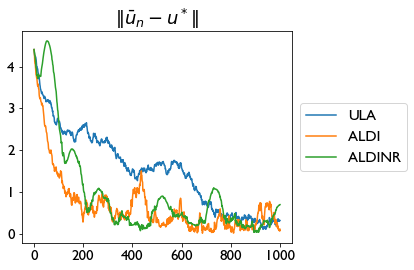

In [7]:
distances_to_mean_ULA = np.linalg.norm(means_ULA, axis=0)
plt.plot(distances_to_mean_ULA, label = 'ULA' )

distances_to_mean_ALDI = np.linalg.norm(means_ALDI, axis=0)
plt.plot(distances_to_mean_ALDI, label = 'ALDI' )

distances_to_mean_ALDINR = np.linalg.norm(means_ALDINR, axis=0)
plt.plot(distances_to_mean_ALDINR, label = 'ALDINR')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(r'$\Vert \bar{u}_n - u^*\Vert$')
plt.tight_layout()

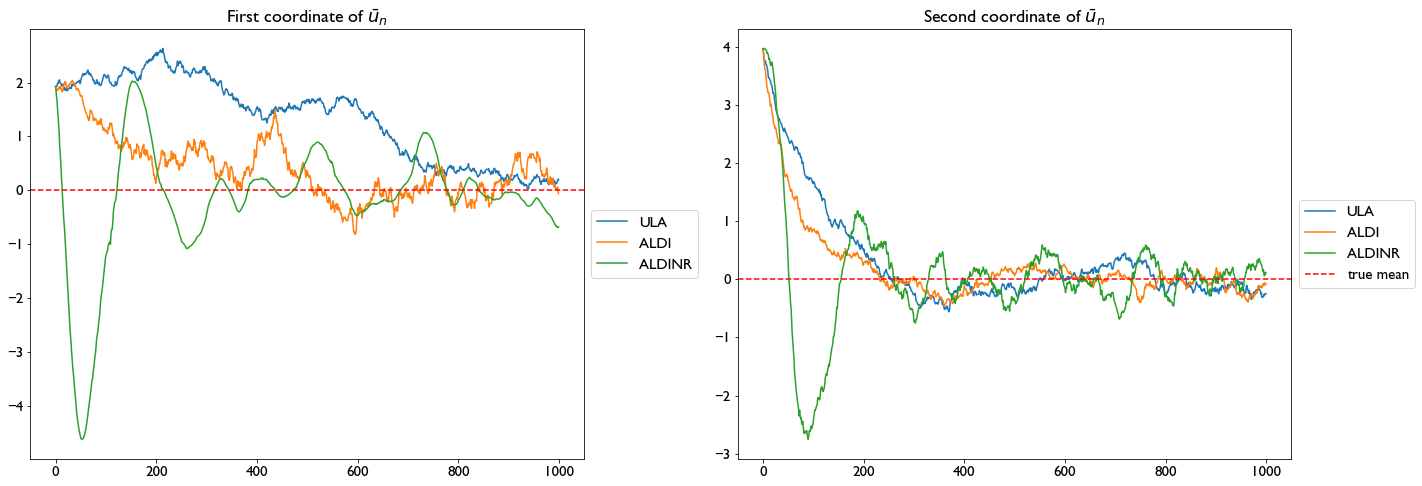

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(7)
fig.set_figwidth(20)

plt.subplot(1, 2, 1)

plt.plot(means_ULA[0, :], label = 'ULA' )
plt.plot(means_ALDI[0, :], label = 'ALDI' )
plt.plot(means_ALDINR[0, :], label = 'ALDINR')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.title('First coordinate of '+ r'$\bar{u}_n$')

plt.subplot(1, 2, 2)
plt.plot(means_ULA[1, :], label = 'ULA' )
plt.plot(means_ALDI[1, :], label = 'ALDI' )
plt.plot(means_ALDINR[1, :], label = 'ALDINR')
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Second coordinate of '+ r'$\bar{u}_n$')
plt.tight_layout()

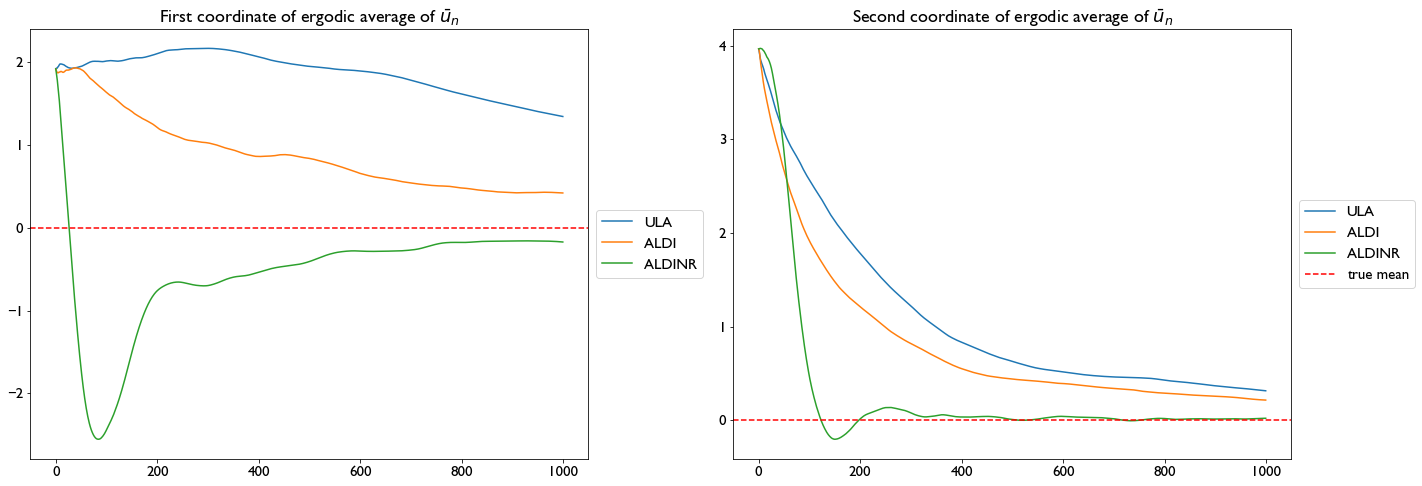

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(7)
fig.set_figwidth(20)

# ergodic average
average_means_ULA = np.asarray([np.mean(means_ULA[:, :i], axis = 1) for i in range(1, N_sim + 1)])
average_means_ALDI =  np.asarray([np.mean(means_ALDI[:, :i], axis = 1) for i in range(1, N_sim + 1)])
average_means_ALDINR = np.asarray([np.mean(means_ALDINR[:, :i], axis = 1) for i in range(1, N_sim + 1)])

plt.subplot(1, 2, 1)
plt.plot(average_means_ULA[:, 0], label = 'ULA' )
plt.plot(average_means_ALDI[:, 0], label = 'ALDI' )
plt.plot(average_means_ALDINR[:, 0], label = 'ALDINR')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.title('First coordinate of ergodic average of '+ r'$\bar{u}_n$')

plt.subplot(1, 2, 2)
plt.plot(average_means_ULA[:, 1], label = 'ULA' )
plt.plot(average_means_ALDI[:, 1], label = 'ALDI' )
plt.plot(average_means_ALDINR[:, 1], label = 'ALDINR')
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Second coordinate of ergodic average of '+ r'$\bar{u}_n$')
plt.tight_layout()

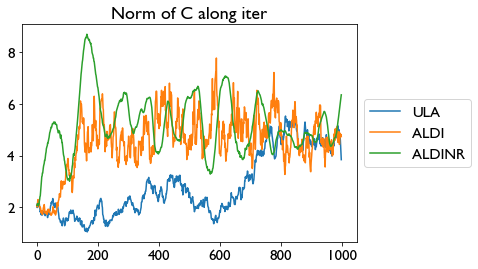

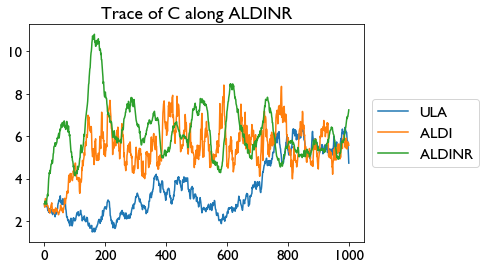

In [10]:

distances_to_covariances_ULA = np.asarray([np.linalg.norm(covariances_ULA[:, :, i]) for i in range(covariances_ULA.shape[2])])
plt.plot(distances_to_covariances_ULA, label ='ULA')

distances_to_covariances_ALDI = np.asarray([np.linalg.norm(covariances_ALDI[:, :, i]) for i in range(covariances_ALDI.shape[2])])
plt.plot(distances_to_covariances_ALDI, label ='ALDI')

distances_to_covariances_ALDINR = np.asarray([np.linalg.norm(covariances_ALDINR[:, :, i]) for i in range(covariances_ALDINR.shape[2])])
plt.plot(distances_to_covariances_ALDINR, label ='ALDINR')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Norm of C along iter')
plt.show()

traces_of_C_ULA = np.asarray([np.trace(covariances_ULA[:, :, i]) for  i in range(covariances_ULA.shape[2])] )
traces_of_C_ALDI = np.asarray([np.trace(covariances_ALDI[:, :, i]) for  i in range(covariances_ALDI.shape[2])] )
traces_of_C_ALDINR = np.asarray([np.trace(covariances_ALDINR[:, :, i]) for  i in range(covariances_ALDINR.shape[2])] )

plt.plot(traces_of_C_ULA, label ='ULA')
plt.plot(traces_of_C_ALDI, label ='ALDI')
plt.plot(traces_of_C_ALDINR, label ='ALDINR')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Trace of C along ALDINR')
plt.show()

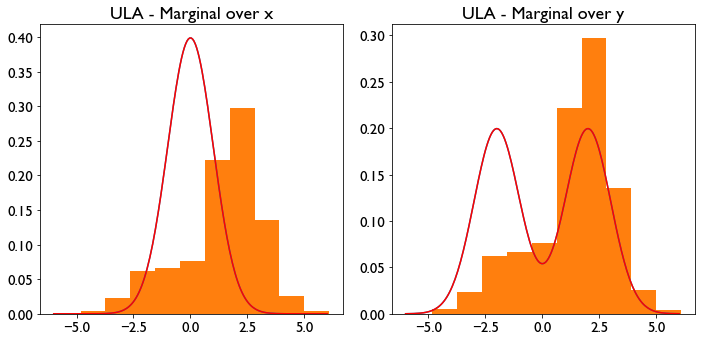

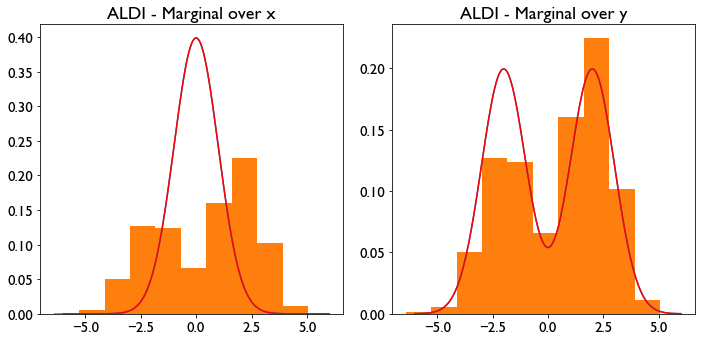

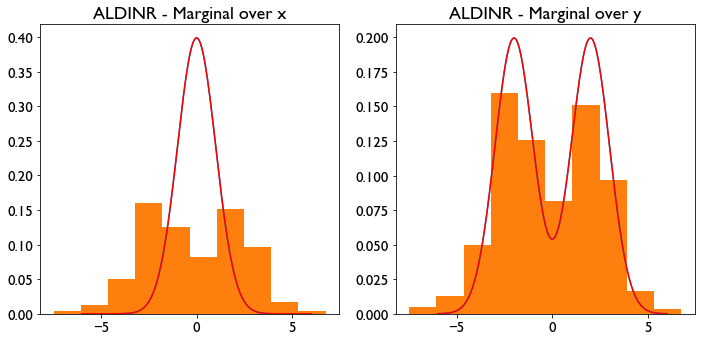

In [11]:
# Plot marginals

plot_marginals_histogram(us_list_ULA, target_unnorm_density, 'ULA')
plot_marginals_histogram(us_list_ALDI, target_unnorm_density, 'ALDI')
plot_marginals_histogram(us_list_ALDINR, target_unnorm_density, 'ALDINR')
